In [1]:
import pandas as pd
import numpy as np
import datetime, random

### Previous method: Function-based implementation (NO LONGER WORKING -- UPDATED akiFlagger.py -- see github for previous commit )

In [2]:
%%time
import akiFlagger
covid_df = pd.read_csv(r'H:\Data\Standardized AKI definition\dataset\covid creatinines.csv')
covid_df['mrn'] = covid_df.pat_mrn_id.str.strip('MR').astype('int')
covid_df['enc'] = covid_df.enc_id
covid_df['time'] = pd.to_datetime(covid_df.time)
covid_df['sex'] = covid_df.sex.astype('bool')
covid_df['race'] = covid_df.race.astype('bool')
covid_df['inpatient'] = covid_df.inpatient.astype('bool')
covid_df['creat'] = covid_df['creatinine']
covid_df['admission'] = pd.to_datetime(covid_df.admission)
covid_df['discharge'] = pd.to_datetime(covid_df.discharge)
print('Shape:', covid_df.shape)
print(covid_df.dtypes)

df = covid_df[['mrn', 'enc', 'time', 'creat', 'age', 'sex', 'race', 'inpatient', 'admission', 'discharge']]
df = df[:10100]
df = df.set_index(['enc', 'time'])[~df.index.duplicated()] #The rows where the pat_enc_csn_id was lumped into enc_id become duplicates
df = df.groupby('enc', sort=False, as_index=False).apply(lambda d: d.sort_values('time'))
df = df.droplevel(0).reset_index()
#p  =akiFlagger.returnAKIpatients(df, aki_calc_type = 'rolling_window')
#pbc=akiFlagger.returnAKIpatients(df, aki_calc_type = 'back_calculate')
#p.head()

Shape: (450399, 16)
pat_mrn_id                 object
PAT_ENC_CSN_ID              int64
time               datetime64[ns]
creatinine                float64
hosp_admsn_time            object
hosp_disch_time            object
enc_id                      int64
admission          datetime64[ns]
discharge          datetime64[ns]
age                       float64
sex                          bool
race                         bool
inpatient                    bool
mrn                         int32
enc                         int64
creat                     float64
dtype: object
Wall time: 2.47 s


### Class-based implementations for akiFlagger 
So that the required column names can be independent of my naming system (& other benefits, of course)

In [3]:
class AKIFlagger:
    '''Flagger to detect patients with acute kidney injury (AKI).
    '''
    def __init__(self, patient_id = 'mrn', creatinine='creatinine', time = 'time', inpatient = 'inpatient', 
                 aki_calc_type=None, keep_extra_cols = False, eGFR_impute = False, add_stages = None,
                 cond1time = '48hours', cond2time = '168hours', pad1time = '0hours', pad2time = '0hours', 
                 rolling_window = False, back_calculate = False,
                 admission = 'admission', age = 'age', sex = 'sex', race = 'race', encounter_id = 'enc',
                 baseline_creat = 'baseline_creat'):
        
        #Identifiers
        self.patient_id = patient_id
        self.encounter_id = encounter_id
        
        #Columns necessary for calculation (if admission not included it will be imputed)
        self.creatinine = creatinine
        self.time = time
        self.inpatient = inpatient
        self.admission = admission
        
        #Demographic variables
        self.age = age
        self.sex = sex
        self.race = race
        
        #Rolling-window variables
        self.cond1time = cond1time
        self.cond2time = cond2time
        self.pad1time = pad1time
        self.pad2time = pad2time
        
        #Back-calculate variables
        self.baseline_creat = baseline_creat
        
        #Extra options to specify what is included in the output
        self.eGFR_impute = eGFR_impute
        self.add_stages = add_stages
        self.keep_extra_cols = keep_extra_cols
        
        #Specifying the calculation type wanted in the flagger
        self.aki_calc_type = aki_calc_type
        self.rolling_window = rolling_window
        self.back_calculate = back_calculate
        
        if self.aki_calc_type is not None:
            if self.aki_calc_type == 'rolling_window':
                self.rolling_window = True
            elif self.aki_calc_type == 'back_calculate':
                self.back_calculate = True
            elif self.aki_calc_type == 'both':
                self.rolling_window = True
                self.back_calculate = True
            
    def returnAKIpatients(self, df, add_stages = None, 
                          cond1time = None, cond2time = None, pad1time = None, pad2time = None):
        '''
        Returns patients with AKI according to the KDIGO guidelines. The KDIGO guidelines are as follows:

        * *Stage 1:* 0.3 increase in serum creatinine in < 48 hours OR 50% increase in serum creatinine in < 7 days (168 hours)
        * *Stage 2:* 100% increase in (or doubling of) serum creatinine in < 7 days (168 hours)
        * *Stage 3:* 200% increase in (our tripling of) serum creatinine in < 7 days (168 hours)

        More information can be found in the documentation at akiflagger.readthedocs.io
        Args: 
            df (pd.DataFrame): Patient dataframe, should include some sort of patient and encounter identifier(s) and age, sex, race, serum creatinine and timestamps.
        Returns:
            df (pd.DataFrame): Patient dataframe with AKI patients identified. 

        Raises:
            AssertionError: If the dataframe is missing an expected column; e.g. if there is no age/sex/race and eGFR_impute is True.

        '''
        if add_stages is None:
            add_stages = self.add_stages
        self.add_stages = add_stages
        
        if cond1time is None:
            cond1time = self.cond1time
        self.cond1time = cond1time
        
        if cond2time is None:
            cond2time = self.cond2time
        self.cond2time = cond2time
        
        if pad1time is None:
            pad1time = self.pad1time
        self.pad1time = pad1time
        
        if pad2time is None:
            pad2time = self.pad2time
        self.pad2time = pad2time
        
        if self.admission not in df.columns:
            df = self.addAdmissionColumn(df, add_encounter_col = self.encounter_id not in df.columns)
            df = df[~df[self.admission].isnull()]
            
        if self.rolling_window: 
            df = df.groupby(self.patient_id, sort=False, as_index=False).apply(lambda d: self.addRollingWindowAKI(d))
            df = df.reset_index(level=0, drop=True).reset_index() #this will leave time as the index
            
        if self.back_calculate:
            df = df.groupby(self.patient_id, sort=False, as_index=False).apply(lambda d: d.sort_values(self.time)).reset_index(drop=True)
            df = df.groupby(self.patient_id, sort=False).apply(lambda d: self.addBaselineCreat(d, 
                                                                                               eGFR_impute=self.eGFR_impute))

            df = df.groupby(self.encounter_id, sort=False, as_index=False).apply(lambda d: self.addBackCalcAKI(d))
            df = df.reset_index(level=0, drop=True).reset_index()
            
        if not self.keep_extra_cols:
            if self.rolling_window or self.aki_calc_type == 'both' or self.aki_calc_type == 'rolling_window':
                df = df.drop([self.mint1_colname, self.mint2_colname, self.delt1_colname, self.delt2_colname], axis=1)
            if self.back_calculate or self.aki_calc_type == 'both' or self.aki_calc_type == 'back_calculate':
                df = df.drop([self.baseline_creat], axis = 1)
        return df
    
    def addRollingWindowAKI(self, df):
        '''
        Adds the AKI conditions based on rolling window definition: 

        * *Stage 1:* 0.3 increase in serum creatinine in < 48 hours OR 50% increase in serum creatinine in < 7 days (168 hours)
        * *Stage 2:* 100% increase in (or doubling of) serum creatinine in < 48 hours
        * *Stage 3:* 200% increase in (our tripling of) serum creatinine in < 48 hours

        Args: 
            df (pd.DataFrame): dataframe, typically of a single encounter.
            add_stages (bool): boolean, default **True**. 
                Choose whether or not to delineate the rolling-window AKI into the three stages (if False it will just lump Stage 1/2/3 into a boolean True/False)
            cond1time (str): string, default **'48hours'**. 
                The amount of time for the rolling-window according to the first criterion; i.e. 0.3 increase in creatinine in ``cond1time`` hours. 
            cond2time (str): string, default **'168hours'**. 
                The amount of time for the rolling-window according to the second criterion; i.e. 50% increase in creatinine in ``cond2time`` hours.

        Returns: 
            df (pd.DataFrame): dataframe with rolling-window aki values added in
        '''
        df = df.set_index(self.time).sort_index()
        df_rw = df.loc[df.admission[0] - pd.Timedelta(hours=172):]
        
        t1 = pd.Timedelta(self.cond1time) + pd.Timedelta(self.pad1time)
        t2 = pd.Timedelta(self.cond2time) + pd.Timedelta(self.pad2time)
        
        minc_t1, minc_t2 = np.empty(df.shape[0]), np.empty(df.shape[0])
        minc_t1[:], minc_t2[:] = np.nan, np.nan 
        minc_t1[df.shape[0]-df_rw.shape[0]:] = df_rw[self.creatinine].rolling(t1, min_periods=1).min().values
        minc_t2[df.shape[0]-df_rw.shape[0]:] = df_rw[self.creatinine].rolling(t2, min_periods=1).min().values

        self.mint1_colname = 'mincreat_{}'.format(t1.days*24 + t1.seconds // 3600)
        self.mint2_colname = 'mincreat_{}'.format(t2.days*24 + t2.seconds // 3600)
        self.delt1_colname = 'deltacreat_{}'.format(t1.days*24 + t1.seconds // 3600)
        self.delt2_colname = 'deltacreat_{}'.format(t2.days*24 + t2.seconds // 3600)
        
        df[self.mint1_colname] = minc_t1
        df[self.mint2_colname] = minc_t2

        df[self.delt1_colname] = np.round(df.creat - df[self.mint1_colname], decimals = 5)
        df[self.delt2_colname] = np.round(df.creat - df[self.mint2_colname], decimals = 5)

        if self.add_stages:
            df['stage1'] = (df[self.delt1_colname] >= 0.3) | (df[self.delt2_colname] >= 0.5*df[self.mint2_colname])
            df['stage2'] = df[self.delt2_colname] >= 2*df[self.mint2_colname]
            df['stage3'] = df[self.delt2_colname] >= 3*df[self.mint2_colname]
            
        df['rollingwindow_aki'] = 1*df.stage1 + 1*df.stage2 + 1*df.stage3 if self.add_stages else (df[self.delt1_colname] >= 0.3) | (df[self.delt2_colname] >= 0.5*df[self.mint2_colname])
  
        return df
    
    def addAdmissionColumn(self, df, add_encounter_col = None):

        pat_gb = df.groupby(self.patient_id)

        #Check for those rows which are all inpatient; e.g. a hospital visit
        df.loc[:, 'all_inp'] = pat_gb.inpatient.transform(lambda d: np.all(d))
        df.loc[:, 'all_inp'] = df.all_inp & ~pat_gb.all_inp.shift(1, fill_value=False)

        df.loc[:, self.admission] = df.inpatient & ~pat_gb.inpatient.shift(1, fill_value=False)
        df.loc[:, self.admission] = df[np.logical_or(df.admission, df.all_inp)].time
        df.loc[:, self.admission] = pat_gb.admission.apply(lambda s: s.bfill().ffill())

        if add_encounter_col:
            df.loc[:, self.encounter_id] = df.inpatient & ~pat_gb.inpatient.shift(1, fill_value=False)
            df.loc[df[self.encounter_id], self.encounter_id] = np.arange(1, df.enc.sum()+1)
            df.loc[df[self.encounter_id] == False, self.encounter_id] = np.nan
            df.loc[:,self.encounter_id] = pat_gb[self.encounter_id].apply(lambda s: s.bfill().ffill())
        df = df.drop(['all_inp'], axis=1)
        
        return df

    def addBackCalcAKI(self, df):
        '''
        Adds the back-calculated AKI conditions, the KDIGO standards on the outpatient values;
        i.e. a 50% increase from baseline creatinine in <7 days. Back-calculated AKI is based on the baseline creatinine, defined in the addBaselineCreat() function.

        Args: 
            df (pd.DataFrame): dataframe, typically of a single encounter. 

        Returns: 
            df (pd.DataFrame): dataframe with back-calculated aki values added in
        '''

        df = df.reset_index(drop=True).set_index(self.time)
        df = df[~df.index.duplicated()]
        #Look back 6 hours prior to admission
        t_lf = pd.Timedelta(self.cond2time) + pd.Timedelta(self.pad2time) #Look forward time is cond2time + padding
        df_lf = df.loc[(df[self.admission] - datetime.timedelta(hours=6)).values[0]:(df[self.admission] + t_lf).values[0]]
        df.loc[df_lf.index, 'backcalc_aki'] = df_lf[self.creatinine] >= np.round(1.5*df_lf[self.baseline_creat], decimals=5)
        df.loc[df.backcalc_aki.isnull(), 'backcalc_aki'] = False

        return df
    
    def addBaselineCreat(self, df, eGFR_impute = None):
        '''
        Adds the baseline creatinine to a dataframe. The baseline creatinine is defined as the median of the outpatient 
        creatinine values from 365 to 7 days prior to admission.

        Args: 
            df (pd.DataFrame): dataframe, typically of a single patient.
            eGFR_impute (bool): boolean, whether or not to impute the null baseline creatinines with the age/sex/race and eGFR of 75

        Returns: 
            df (pd.DataFrame): dataframe with baseline creatinine values added in

        '''
        if eGFR_impute is None:
            eGFR_impute = self.eGFR_impute
        self.eGFR_impute = eGFR_impute

        split_dfs = list()
        unique_adms = df[self.admission].unique()
        for adm in unique_adms[~np.isnat(unique_adms)]:
            adm_df = df.loc[df[self.admission] == adm]
            adm_df.loc[:,self.baseline_creat] = adm_df[~adm_df[self.inpatient]].set_index(self.time).loc[adm - pd.Timedelta(days=365):adm - pd.Timedelta(days=7), self.creatinine].median()
            split_dfs.append(adm_df)
        
        df = pd.concat(split_dfs)

        if self.eGFR_impute:
                df.loc[df[self.baseline_creat].isnull(), self.baseline_creat] = df[df[self.baseline_creat].isnull()].apply(lambda d: self.eGFRbasedCreatImputation(d[self.age], d[self.sex], d[self.race]), axis=1)

        return df
    
    def eGFRbasedCreatImputation(self, age, sex, race):
        '''
        Imputes the baseline creatinine values for those patients missing outpatient creatinine measurements from 365 to 7 days prior to admisison.
        The imputation is based on the `CKD-EPI equation <https://www.niddk.nih.gov/health-information/professionals/clinical-tools-patient-management/kidney-disease/laboratory-evaluation/glomerular-filtration-rate/estimating>`_ 
        from the paper *A New Equation to Estimate Glomerular Filtration Rate (Levey et. Al, 2009)* linked below. 

        We assume a GFR of 75 (mL/min/1.73 m^2) and then estimate a creatinine value based on the patient demographics.

        Equation: https://www.niddk.nih.gov/health-information/professionals/clinical-tools-patient-management/kidney-disease/laboratory-evaluation/glomerular-filtration-rate/estimating

        Full paper: https://pubmed.ncbi.nlm.nih.gov/19414839/

        Args:
            age (float or array of floats): the age(s) of the patient(s).
            sex (bool or array of bools): whether or not the patient is female (female is True).
            race (bool or array of bools): whether or not the patient is black (black is True).

        Returns:
            creat (float or array of floats): the imputed creatinine value(s) of the patient(s).
        '''
        #The hard-coded constants, kappa, and alpha correspond to those used by the authors and the CKD-EPI equation, linked in the docstrings
        kappa  = (0.9 - 0.2*sex)
        alpha  = (-0.411+0.082*sex)
        creat_over_kappa = 75/(141*(1 + 0.018*sex)*(1 + 0.159*race)*0.993**age)

        #Note that if creat/kappa is < 1 then the equation simplifies to creat_over_kappa = (creat/kappa)**(-1.209)
        # and if creat/kappa is > 1 then the equation simplifies to (creat/kappa)**alpha. Thus, we can replace the min(~)max(~)
        #statements with the following check to define the creatinine.
        if creat_over_kappa < 1:
            creat = kappa*creat_over_kappa**(-1/1.209)
        elif creat_over_kappa >= 1:
            creat = kappa*creat_over_kappa**(1/alpha)
        return creat

    def eGFR(self, creat, age, female, black): 
        '''
        Calculates the estimated glomerular filtration rate based on the serum creatinine levels, age, sex, and race.
        Based on the formula in the paper A New Equation to Estimate Glomerular Filtration Rate (Levey et. Al, 2009) linked below.

        Equation: https://www.niddk.nih.gov/health-information/professionals/clinical-tools-patient-management/kidney-disease/laboratory-evaluation/glomerular-filtration-rate/estimating

        Full paper: https://pubmed.ncbi.nlm.nih.gov/19414839/

        Args:
            creat (float or array of floats): the creatinine value(s) of the patient(s).
            age (float or array of floats): the age(s) of the patient(s).
            female (bool or array of bools): whether or not the patient is female (female is True).
            black (bool or array of bools): whether or not the patient is black (black is True).

        Returns:
            egfr (float or array of floats): the estimated glomerular filtration rate based on the CKD-EPI equation.
        '''

        min_ck = np.clip(creat/(0.9-0.2*female), a_min=None, a_max=1) #Equivalent to min(cr/k, 1)
        max_ck = np.clip(creat/(0.9-0.2*female), a_min=1, a_max=None) #Equivalent to max(cr/k, 1)

        alpha = (-0.411+0.082*female)

        egfr = 141*(0.993**age)*(min_ck**alpha)*(max_ck**-1.209)*(1+female*0.018)*(1+black*0.159)

        return np.round(egfr, decimals=5) 

    def generate_toy_data(self, num_patients = 100, 
                          num_encounters_range = (3, 10), include_demographic_info = False,
                          date_range = None, time_deltas = None, creat_scale = 0.3):
        '''
        Generates toy data for demonstrating how the flagger works.

        Args:
            num_patients (int): integer, default 100.
                Number of patients to generate
            num_encounters_range (tuple): tuple, default (3, 10).
                Number of encounters per patient will be randomly selected from a range between this tuple.
            include_demographic_info (bool): boolean, default False. 
                Whether or not to include the demographic information in the generated dataset


        Returns:
            df (pd.DataFrame): dataframe with toy numbers to work with.

        '''
        np.random.seed(0) #seed for reproducibility

        #To explicitly demonstrate that race and sex variables only care about black/female distinction
        self.race = 'black'
        self.sex = 'female'
        
        #pick admission dates from Jan 1, 2020 to July 1, 2020 (6 month period) and generate time deltas from +- 5 days
        if date_range is None:
            date_range = (pd.to_datetime('2020-01-01').value // 10**9, pd.to_datetime('2020-07-01').value // 10**9) 
        if time_deltas is None:
            time_deltas = pd.timedelta_range(start='-5 days', end='5 days', freq='6H')

        #Generate random MRN #s, admission dates, and encounters
        #Generate between 3 and 10 encounters for each patient
        mrns = np.random.randint(10000, 20000, num_patients)
        admns = pd.to_datetime(np.random.randint(date_range[0], date_range[1], num_patients), unit = 's')
        encs = [np.random.randint(10000, 99999, np.random.randint(num_encounters_range[0],num_encounters_range[1])) for mrn, admn in zip(mrns, admns)]
        creats = np.clip(np.random.normal(loc = 1, scale = creat_scale, size=num_patients), a_min = 0, a_max = None)

        #Combine the two dataframes
        d1 = pd.DataFrame([mrns, admns, creats]).T
        d2 = pd.DataFrame(encs)

        d1.columns = [self.patient_id, self.admission, self.baseline_creat]
        d2 = d2.add_prefix('enc_')

        if include_demographic_info:
            ages = np.random.normal(loc = 60, scale = 5, size=num_patients)
            race = np.random.rand(num_patients) > 0.85
            sex = np.random.rand(num_patients) > 0.5

            d1 = pd.DataFrame([mrns, admns, creats, ages, race, sex]).T
            d1.columns = [self.patient_id, self.admission, self.baseline_creat, self.age, self.race, self.sex]

        df = pd.concat([d1, d2], axis=1)
        df = pd.melt(df, id_vars = d1.columns, value_name = self.encounter_id).drop('variable', axis=1)

        #Remove the duplicated & null values and reset the index
        df = df[np.logical_and(~df[self.encounter_id].isnull(), ~df[self.encounter_id].duplicated())].reset_index(drop=True) 

        df[self.creatinine] = np.clip(df[self.baseline_creat] + np.random.normal(loc = 0, scale = 0.25, size = df.shape[0]), a_min = 0.1, a_max = None).astype('float')
        df[self.time] = df[self.admission] + pd.to_timedelta([random.choice(time_deltas) for i in range(df.shape[0])])
        df[self.inpatient] = df[self.time] > df[self.admission]
        
        df[self.patient_id] = df[self.patient_id].astype('int')
        df[self.encounter_id] = df[self.encounter_id].astype('int')
        
            
        df = df.groupby(self.patient_id, sort=False, as_index=False).apply(lambda d: d.sort_values(self.time))
        df = df.reset_index(drop=True)
        
        if include_demographic_info:
            df = df[[self.patient_id, self.encounter_id, self.age, self.race, self.sex, self.inpatient, self.admission, self.time, self.creatinine]]
            print('Successfully generated toy data!')
            return df
        
        df = df[[self.patient_id, self.encounter_id, self.inpatient, self.admission, self.time, self.creatinine]]
        print('Successfully generated toy data!')
        return df

In [4]:
#Working on increasing efficiency - UPDATE: holy crap this is so much quicker!! This is awesome :) 
class AKIFlagger2:
    def __init__(self, patient_id = 'mrn', creatinine='creatinine', time = 'time', inpatient = 'inpatient', 
                 aki_calc_type=None, keep_extra_cols = False, eGFR_impute = False, add_stages = False,
                 cond1time = '48hours', cond2time = '168hours', pad1time = '0hours', pad2time = '0hours', 
                 rolling_window = False, back_calculate = False,
                 admission = 'admission', age = 'age', sex = 'sex', race = 'race', encounter_id = 'enc',
                 baseline_creat = 'baseline_creat', sort_values = True, remove_bc_na = True, add_baseline_creat = False):
        
        self.aki_calc_type = aki_calc_type
        self.patient_id = patient_id
        self.creatinine = creatinine
        self.time = time
        self.inpatient = inpatient
        
        #Identifiers
        self.patient_id = patient_id
        self.encounter_id = encounter_id
        
        #Columns necessary for calculation (if admission not included it will be imputed)
        self.creatinine = creatinine
        self.time = time
        self.inpatient = inpatient
        self.admission = admission
        
        #Demographic variables
        self.age = age
        self.sex = sex
        self.race = race
        
        #Rolling-window variables
        self.cond1time = pd.Timedelta(cond1time) + pd.Timedelta(pad1time)
        self.cond2time = pd.Timedelta(cond2time) + pd.Timedelta(pad2time)
        
        #Back-calculate variables
        self.baseline_creat = baseline_creat
        
        #Extra options to specify what is included in the output
        self.eGFR_impute = eGFR_impute
        self.add_stages = add_stages
        self.keep_extra_cols = keep_extra_cols
        self.remove_bc_na = remove_bc_na
        self.add_baseline_creat = add_baseline_creat
        
        #Specifying the calculation type wanted in the flagger
        self.aki_calc_type = aki_calc_type
        self.rolling_window = rolling_window
        self.back_calculate = back_calculate
        
        if self.aki_calc_type is not None:
            if self.aki_calc_type == 'rolling_window':
                self.rolling_window = True
            elif self.aki_calc_type == 'back_calculate':
                self.back_calculate = True
            elif self.aki_calc_type == 'both':
                self.rolling_window = True
                self.back_calculate = True
        if self.rolling_window and self.back_calculate:
            self.aki_calc_type = 'both'
        elif self.rolling_window:
            self.aki_calc_type = 'rolling_window'
        elif self.back_calculate:
            self.aki_calc_type = 'back_calculate'
        
    def returnAKIpatients(self, dataframe, add_stages = None, 
                          cond1time = None, cond2time = None, pad1time = None, pad2time = None):
        '''
        Returns patients with AKI according to the KDIGO guidelines. The KDIGO guidelines are as follows:

        * *Stage 1:* 0.3 increase in serum creatinine in < 48 hours OR 50% increase in serum creatinine in < 7 days (168 hours)
        * *Stage 2:* 100% increase in (or doubling of) serum creatinine in < 7 days (168 hours)
        * *Stage 3:* 200% increase in (our tripling of) serum creatinine in < 7 days (168 hours)

        More information can be found in the documentation at akiflagger.readthedocs.io
        Args: 
            df (pd.DataFrame): Patient dataframe, should include some sort of patient and encounter identifier(s) and age, sex, race, serum creatinine and timestamps.
        Returns:
            df (pd.DataFrame): Patient dataframe with AKI patients identified. 

        Raises:
            AssertionError: If the dataframe is missing an expected column; e.g. if there is no age/sex/race and eGFR_impute is True.

        '''
        ## Checks: we need to make sure the required columns are in the dataframe
        assert (self.encounter_id in dataframe.columns or self.patient_id in dataframe.columns), "Patient identifier missing!"
        assert (self.creatinine in dataframe.columns), "Creatinine column missing!"
        assert (self.time in dataframe.columns), "Time column missing!"
        assert (self.inpatient in dataframe.columns), "Inpatient/outpatient column missing!"
        
        ## Step 1: Set the index to encounter & time variables
        
        #First, check if enc in cols or indx
        if self.encounter_id not in dataframe.columns and self.encounter_id not in dataframe.index.names:
            #If no, check if admission in cols or indx
            if self.admission not in dataframe.columns and self.admission not in dataframe.index.names:
                df = self.addAdmissionColumn(dataframe, add_encounter_col = True)
                
            #Otherwise, add encounters based on the unique admissions
            elif self.admission in dataframe.index.names and self.admission in dataframe.columns:
                df = dataframe.copy()
                
                mask = df.groupby(self.admission).head(1).index
                df.loc[mask, self.encounter_id] = np.arange(df[self.admission].unique().shape[0])
                df[self.encounter_id] = df[self.encounter_id].ffill()
        
        #If encounter is in indx/col, of course, we have no problem
        elif self.encounter_id in dataframe.columns or self.encounter_id in dataframe.index.names:
            df = dataframe.set_index([self.encounter_id, self.time])
            
        ## Step 2: Sort based on time and also drop the duplicates
        df = df.groupby(self.encounter_id, sort=False, as_index = False).apply(lambda d: d.sort_index(level=self.time))
        df = df[~df.index.duplicated()]
        
        #Note that at this point we assume enc & time are indices NOT columns
        
        ## Step 3: Add rolling-window and/or back-calculate aki
        if self.rolling_window:
            rw = self.addRollingWindowAKI(df)
        if self.back_calculate:
            baseline_creat = self.addBaselineCreat(df)
            bc = self.addBackCalcAKI(df, baseline_creat = baseline_creat)
        
        if self.aki_calc_type == 'both':
            return pd.concat([df, rw, bc], axis=1).reset_index()
        elif self.rolling_window:
            return pd.concat([df, rw], axis=1).reset_index()
        elif self.back_calculate:
            return pd.concat([df, bc], axis=1).reset_index()
    
    def addAdmissionColumn(self, df, add_encounter_col = None):

        pat_gb = df.groupby(self.patient_id, sort = False)

        #Check for those rows which are all inpatient; e.g. a hospital visit
        df.loc[:, 'all_inp'] = pat_gb.inpatient.transform(lambda d: np.all(d))
        df.loc[:, 'all_inp'] = df.all_inp & ~pat_gb.all_inp.shift(1, fill_value=False)

        df.loc[:, self.admission] = df.inpatient & ~pat_gb.inpatient.shift(1, fill_value=False)
        df.loc[:, self.admission] = df[np.logical_or(df.admission, df.all_inp)].time
        df.loc[:, self.admission] = pat_gb.admission.apply(lambda s: s.bfill().ffill())

        if add_encounter_col:
            df.loc[:, self.encounter_id] = df.inpatient & ~pat_gb.inpatient.shift(1, fill_value=False)
            df.loc[df[self.encounter_id], self.encounter_id] = np.arange(1, df.enc.sum()+1)
            df.loc[df[self.encounter_id] == False, self.encounter_id] = np.nan
            df.loc[:,self.encounter_id] = pat_gb[self.encounter_id].apply(lambda s: s.bfill().ffill())
        df = df.drop(['all_inp'], axis=1)
        
        return df   
    
    def addRollingWindowAKI(self, df):
        
        #Set the index to just time 
        tmp = df[self.creatinine].reset_index(self.encounter_id) 
        #Groupby on encounter then apply conditions for rolling-window AKI
        gb = tmp.groupby(self.encounter_id, as_index = True, sort = False)
        gb_indx = gb[self.creatinine].rolling(self.cond1time).min().index
        c1 = tmp.set_index([self.encounter_id, tmp.index.get_level_values(level=self.time)]).loc[gb_indx][self.creatinine] >= 0.3 + gb[self.creatinine].rolling(self.cond1time).min()
        c2 = tmp.set_index([self.encounter_id, tmp.index.get_level_values(level=self.time)]).loc[gb_indx][self.creatinine] >= 1.5*gb[self.creatinine].rolling(self.cond2time).min()
        
        stage1 = np.logical_or(c1, c2)
        stage2 = tmp.set_index([self.encounter_id, tmp.index.get_level_values(level=self.time)]).loc[gb_indx][self.creatinine].values >= 2*gb[self.creatinine].rolling(self.cond2time).min()
        stage3 = tmp.set_index([self.encounter_id, tmp.index.get_level_values(level=self.time)]).loc[gb_indx][self.creatinine].values >= 3*gb[self.creatinine].rolling(self.cond2time).min()
        
        if self.add_stages:
            assert (np.all(stage1.index == df.index))
            return pd.Series(stage3.add(stage2.add(stage1*1)), name = 'rw')
        
        #assert (np.all(stage1.index == df.index)), 'Index mismatch! Something went wrong...'
        rw = pd.Series(np.logical_or.reduce((stage1, stage2, stage3)), index = stage1.index,
                         name = 'rw')
        rw = rw.reindex(df.index)
        assert (np.all(rw.index == df.index)), 'Index mismatch! Something went wrong...'
        return rw
    
    def addBaselineCreat(self, df):
    
        #Baseline creatinine is defined as the MEDIAN of the OUTPATIENT values from 365 to 7 days prior to admission

        #First, subset on columns necessary for calculation: creatinine, admission & inpatient/outpatient
        tmp = df.loc[:,[self.creatinine, self.admission, self.inpatient]]

        #Next, create a T/F mask for the times between 365 & 7 days prior to admission AND outpatient vals 
        bc_tz = np.logical_and(tmp[self.admission] - pd.Timedelta(days=365) <= tmp.index.get_level_values(level=self.time),
                           tmp[self.admission] - pd.Timedelta(days=7) >= tmp.index.get_level_values(level=self.time))
        mask = np.logical_and(bc_tz, ~tmp[self.inpatient])
        
        #Finally, add the median creat values to the dataframe, forward-fill, and return
        tmp.loc[mask, self.baseline_creat] = tmp[mask].groupby(self.encounter_id, as_index=True).creat.transform('median')
        tmp[self.baseline_creat] = tmp.groupby(self.encounter_id)[self.baseline_creat].ffill()
        
        #Still need to figure out the eGFR_impute conditional ~ ~ ~ ~ ~ that will go here ~ ~ ~ ~ ~ ~ ~ ~
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~I was up at 2am when I did this~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
        return tmp.baseline_creat
    
    def addBackCalcAKI(self, df, baseline_creat=None):
        
        #Subset on necessary cols: creat + admn
        tmp = df.loc[:, [self.creatinine, self.admission]]
        
        #Look back 6 hours prior to admission until cond2time from admission
        mask = np.logical_and(tmp[self.admission] - pd.Timedelta(hours=6) <= tmp.index.get_level_values(level = self.time),
                              tmp[self.admission] + self.cond2time >= tmp.index.get_level_values(level = self.time))
        
        #Apply aki definition & return the resulting series (the reason we add it to the data frame is so we can get
        # the NaNs in the right place without doing much work as a "freebie")
        tmp.loc[mask, 'bc'] = tmp[mask][self.creatinine] >= 1.5*baseline_creat[mask]
        
        #And by default, I'll replace the null values with False's 
        if self.remove_bc_na:
            tmp.loc[tmp.bc.isnull(), 'bc'] = False
        return tmp.bc
    
def generate_toy_data(num_patients = 100, num_encounters_range = (1, 3), num_time_range = (5,10),
                      include_demographic_info = False, date_range = None, time_delta_range = None, creat_scale = 0.3):
        '''
        Generates toy data for demonstrating how the flagger works.

        Args:
            num_patients (int): integer, default 100.
                Number of patients to generate
            num_encounters_range (tuple): tuple, default (3, 10).
                Number of encounters per patient will be randomly selected from a range between this tuple.
            include_demographic_info (bool): boolean, default False. 
                Whether or not to include the demographic information in the generated dataset


        Returns:
            df (pd.DataFrame): dataframe with toy numbers to work with.

        '''
        np.random.seed(0) #seed for reproducibility

        #To explicitly demonstrate that race and sex variables only care about black/female distinction
        race = 'black'
        sex = 'female'
        age = 'age'
        
        #pick admission dates from Jan 1, 2020 to July 1, 2020 (6 month period) and generate time deltas from +- 5 days
        if date_range is None:
            date_range = (pd.to_datetime('2020-01-01').value // 10**9, pd.to_datetime('2020-07-01').value // 10**9) 
        if time_delta_range is None:
            time_delta_range = pd.timedelta_range(start='-5 days', end='5 days', freq='6H')

        #Generate random MRN #s, admission dates, and encounters
        #Generate between 3 and 10 encounters for each patient
        mrns = np.random.randint(10000, 20000, num_patients)
        admns = pd.to_datetime(np.random.randint(date_range[0], date_range[1], num_patients), unit = 's')
        encs = [np.random.randint(10000, 99999, np.random.randint(num_encounters_range[0],num_encounters_range[1])) for mrn, admn in zip(mrns, admns)]
        creats = np.clip(np.random.normal(loc = 1, scale = creat_scale, size=num_patients), a_min = 0, a_max = None)

        #Combine the two dataframes
        d1 = pd.DataFrame([mrns, admns, creats]).T
        d2 = pd.DataFrame(encs)

        patient_id, encounter_id, time, admission, inpatient, creatinine, baseline_creat = 'mrn','enc','time','admission','inpatient', 'creat', 'baseline_creat'
        d1.columns = [patient_id, admission, baseline_creat]
        d2 = d2.add_prefix('enc_')

        if include_demographic_info:
            ages = np.random.normal(loc = 60, scale = 5, size=num_patients)
            race = np.random.rand(num_patients) > 0.85
            sex = np.random.rand(num_patients) > 0.5

            d1 = pd.DataFrame([mrns, admns, creats, ages, race, sex]).T
            d1.columns = [patient_id, admission, baseline_creat, age, 'black', 'female']

        df1 = pd.concat([d1, d2], axis=1)
        df1 = pd.melt(df1, id_vars = d1.columns, value_name = 'enc').drop('variable', axis=1)
        df1 = df1[np.logical_and(~df1[encounter_id].isnull(), ~df1[encounter_id].duplicated())].reset_index(drop=True)
        
        time_deltas = [random.choices(time_delta_range, k=np.random.randint(num_time_range[0],num_time_range[1])) for i in range(df1.shape[0])]
        d3 = pd.DataFrame(time_deltas).add_prefix('time_')
        df = pd.concat([df1, d3], axis=1)
        df = pd.melt(df, id_vars = df1.columns, value_name = 'time').drop('variable', axis=1).dropna().reset_index(drop=True)

        df[creatinine] = np.clip(df[baseline_creat] + np.random.normal(loc = 0, scale = 0.25, size = df.shape[0]), a_min = 0.1, a_max = None).astype('float')
        df[time] = df[time] + df[admission]
        df[inpatient] = df[time] > df[admission]
        
        df[patient_id] = df[patient_id].astype('int')
        df[encounter_id] = df[encounter_id].astype('int')
        
        df = df[~df.time.duplicated()]    
        df = df.groupby(patient_id, sort=False, as_index=False).apply(lambda d: d.sort_values(time))
        df = df.reset_index(drop=True)

        
        if include_demographic_info:
            df = df.loc[:,[patient_id, encounter_id, age, race, sex, inpatient, admission, time, creatinine]]
            print('Successfully generated toy data!')
            return df
        
        df = df.loc[:,[patient_id, encounter_id, inpatient, admission, time, creatinine]]
        print('Successfully generated toy data!')
        return df

In [5]:
toy = generate_toy_data()
print('Shape: ', toy.shape)
print(toy.mrn.unique().shape, toy.enc.unique().shape, toy.time.unique().shape)
flagger = AKIFlagger2(creatinine = 'creat', rolling_window=True)
out = flagger.returnAKIpatients(toy)
out.head()

Successfully generated toy data!
Shape:  (955, 6)
(100,) (153,) (955,)


,enc,time,mrn,inpatient,admission,creat,rw
0,25741,2020-02-22 11:42:42,12732,False,2020-02-27 11:42:42,1.609051,False
1,25741,2020-02-25 17:42:42,12732,False,2020-02-27 11:42:42,1.049753,False
2,25741,2020-02-28 05:42:42,12732,True,2020-02-27 11:42:42,1.260844,False
3,25741,2020-02-29 17:42:42,12732,True,2020-02-27 11:42:42,1.418336,False
4,53986,2020-05-07 12:02:54,19845,False,2020-05-12 06:02:54,0.756843,False


In [6]:
out = out[['mrn', 'enc', 'time', 'inpatient', 'admission', 'creat', 'rw']]
out.head()

,mrn,enc,time,inpatient,admission,creat,rw
0,12732,25741,2020-02-22 11:42:42,False,2020-02-27 11:42:42,1.609051,False
1,12732,25741,2020-02-25 17:42:42,False,2020-02-27 11:42:42,1.049753,False
2,12732,25741,2020-02-28 05:42:42,True,2020-02-27 11:42:42,1.260844,False
3,12732,25741,2020-02-29 17:42:42,True,2020-02-27 11:42:42,1.418336,False
4,19845,53986,2020-05-07 12:02:54,False,2020-05-12 06:02:54,0.756843,False


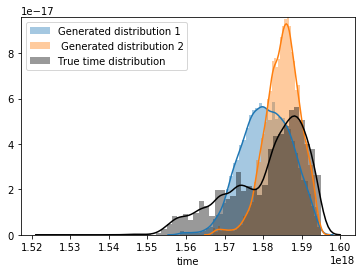

In [7]:
## Just checking the time distributions to see how well my Gaussian approximates the actual distribution...
import matplotlib.pyplot as plt
import seaborn as sns
# I have a choice between getting a similar sigma or a similar mean... for what that's worth =p

time_delta_range = pd.timedelta_range(start='-200 days', end='5 days', freq='6H') # better sigma
time_delta_range2 = pd.timedelta_range(start='-100 days', end='5 days', freq='6H')# better mean

sns.distplot(df['admission'] + pd.to_timedelta([random.choice(time_delta_range) for i in range(df.shape[0])]), label='Generated distribution 1')
sns.distplot(df['admission'] + pd.to_timedelta([random.choice(time_delta_range2) for i in range(df.shape[0])]), label=' Generated distribution 2')
sns.distplot(df.time, label = 'True time distribution', color='black')
plt.legend()

In [8]:
flagger = AKIFlagger2(rolling_window = True, back_calculate = True, creatinine = 'creat')
toy = generate_toy_data()
toy.head()

Successfully generated toy data!


,mrn,enc,inpatient,admission,time,creat
0,12732,25741,False,2020-02-27 11:42:42,2020-02-22 11:42:42,1.057718
1,12732,25741,False,2020-02-27 11:42:42,2020-02-22 17:42:42,1.609051
2,12732,25741,False,2020-02-27 11:42:42,2020-02-24 05:42:42,1.260844
3,12732,25741,False,2020-02-27 11:42:42,2020-02-26 11:42:42,1.418336
4,12732,25741,True,2020-02-27 11:42:42,2020-02-28 11:42:42,1.049753


In [9]:
%%time
flagger = AKIFlagger2(creatinine = 'creat', rolling_window=True, add_stages=True)
rw = flagger.returnAKIpatients(df)
print(rw.rw.value_counts())
#rw.head()

0    8959
1     717
2     109
3      33
Name: rw, dtype: int64
Wall time: 2.06 s


In [10]:
flagger = AKIFlagger2(creatinine = 'creat', back_calculate = True)
bc = flagger.returnAKIpatients(df)
print(bc.bc.value_counts())
#bc.head()

False    9553
True      265
Name: bc, dtype: int64


In [11]:
%%time
f1 = AKIFlagger(rolling_window = True, back_calculate=True, creatinine = 'creat')
out1 = f1.returnAKIpatients(df)
out1 = out1.set_index(['enc', 'time'])
out1 = out1[~out1.index.duplicated()]
print(out1.shape)
print('RW: {}, BC: {}'.format(out1.rollingwindow_aki.sum(), out1.backcalc_aki.sum()))
#ut1.head()

(9818, 10)
RW: 647, BC: 265
Wall time: 11.6 s


In [12]:
%%time
f2 = AKIFlagger2(rolling_window = True, back_calculate = True, creatinine = 'creat')
out = f2.returnAKIpatients(df)
#out.head()

Wall time: 2.25 s


In [13]:
out1['rw_'] = rw.set_index(['enc', 'time']).rw
out1['rw'] = out1.rw_ > 0
out1['bc'] = bc.set_index(['enc', 'time']).bc
print((out1.rollingwindow_aki != out1.rw).sum())
print((out1.backcalc_aki != out1.bc).sum())
#out1.iloc[np.where(out1.rollingwindow_aki != out1.rw)[0]]
check = out1.loc[np.logical_and(out1.rw, out1.inpatient)]
np.all(check.rw == check.rollingwindow_aki) #If this is true, we're good to go :) 

238
0


True

### Test on toy data

In [14]:
flagger = AKIFlagger2(rolling_window = True, back_calculate = True, creatinine = 'creat')
toy = generate_toy_data()
toy.head()

Successfully generated toy data!


,mrn,enc,inpatient,admission,time,creat
0,12732,25741,False,2020-02-27 11:42:42,2020-02-24 17:42:42,1.418336
1,12732,25741,False,2020-02-27 11:42:42,2020-02-25 05:42:42,1.049753
2,12732,25741,False,2020-02-27 11:42:42,2020-02-27 05:42:42,1.260844
3,12732,25741,True,2020-02-27 11:42:42,2020-02-29 11:42:42,1.609051
4,12732,25741,True,2020-02-27 11:42:42,2020-03-01 17:42:42,1.057718


In [16]:
#Potentially a unit test 
flagger = AKIFlagger2()
print(flagger.aki_calc_type, flagger.rolling_window, flagger.back_calculate)
flagger = AKIFlagger2(rolling_window=True)
print(flagger.aki_calc_type, flagger.rolling_window, flagger.back_calculate)
flagger = AKIFlagger2(back_calculate = True)
print(flagger.aki_calc_type, flagger.rolling_window, flagger.back_calculate)
flagger = AKIFlagger2(rolling_window = True, back_calculate = True)
print(flagger.aki_calc_type, flagger.rolling_window, flagger.back_calculate)

None False False
rolling_window True False
back_calculate False True
both True True


### Rolling window: First, checking population-level values to make sure the output hasn't changed

In [ ]:
%%time
flagger = AKIFlagger(rolling_window = True, creatinine = 'creat', add_stages = True)
rw = flagger.returnAKIpatients(df)
print('Stage 1: {} vs {}'.format(rw.stage1.sum(), p.stage1.sum()))
print('Stage 2: {} vs {}'.format(rw.stage2.sum(), p.stage2.sum()))
print('Stage 3: {} vs {}'.format(rw.stage3.sum(), p.stage3.sum()))
print('Unique mrns: {} vs {}'.format(rw.mrn.unique().shape, p.mrn.unique().shape))
print('Unique encs: {} vs {}'.format(rw.enc.unique().shape, p.enc.unique().shape))
print('All match, great!')

### Rolling window: Now against a dataframe with the bare minimum requirements (no admission or encounter columns)

In [ ]:
%%time
noad = df.loc[:,['mrn', 'creat', 'time', 'inpatient']]
rw = flagger.returnAKIpatients(noad)
print('Stage 1: {} vs {}'.format(rw.stage1.sum(), p.stage1.sum()))
print('Stage 2: {} vs {}'.format(rw.stage2.sum(), p.stage2.sum()))
print('Stage 3: {} vs {}'.format(rw.stage3.sum(), p.stage3.sum()))
print('Unique mrns: {} vs {}'.format(rw.mrn.unique().shape, p.mrn.unique().shape))
print('Unique encs: {} vs {}'.format(rw.enc.unique().shape, p.enc.unique().shape))
print('If the numbers are pretty close, we\'re happy with the imputation performed.')

### Back-calculate: First, check with whole dataframe to make sure output remains the same

In [ ]:
%%time
flagger = AKIFlagger(back_calculate = True, creatinine = 'creat')
bc = flagger.returnAKIpatients(df)
print('Back-calc AKI count: {} vs {}'.format(bc.backcalc_aki.sum(), pbc.backcalc_aki.sum()))
print('Unique baseline creats: {} vs {}'.format(bc.baseline_creat.unique().shape, pbc.baseline_creat.unique().shape))
print('Unique mrns: {} vs {}'.format(bc.mrn.unique().shape, pbc.mrn.unique().shape))
print('Unique encs: {} vs {}'.format(bc.enc.unique().shape, pbc.enc.unique().shape))
print('All match, great!')

### Back-calculate: Next, check with bare min input

In [ ]:
%%time
flagger = AKIFlagger(creatinine = 'creat', back_calculate=True)
noad = df.loc[:,['mrn', 'creat', 'time', 'inpatient']]
#noad = noad.groupby('mrn', sort=False, as_index=False).apply(lambda d: d.sort_values('time')).reset_index(drop=True)
bc = flagger.returnAKIpatients(noad)
print('Back-calc AKI count: {} vs {}'.format(bc.backcalc_aki.sum(), pbc.backcalc_aki.sum()))
print('Unique baseline creats: {} vs {}'.format(bc.baseline_creat.unique().shape, pbc.baseline_creat.unique().shape))
print('Unique mrns: {} vs {}'.format(bc.mrn.unique().shape, pbc.mrn.unique().shape))
print('Unique encs: {} vs {}'.format(bc.enc.unique().shape, pbc.enc.unique().shape))
print('The differences are a little more pronounced with back-calc AKI but still not too far off')

### Toy data: First, on the generated output from the class call

In [ ]:
%%time
time_deltas = pd.timedelta_range(start='-20 days', end='20 days', freq='6H')
flagger = AKIFlagger(rolling_window = True, back_calculate = True, creatinine = 'creat',
                     keep_extra_cols = True)
toy = flagger.generate_toy_data(num_patients = 100, time_deltas = time_deltas)
out = flagger.returnAKIpatients(toy)

## Code for generating admission column with intermediate steps as separate columns & edge-case checks

In [ ]:
#Check to make sure that when switching from mrn to mrn it's still capturing admissions 
c1 = np.logical_and(noad.inpatient, noad.inpatient.shift(1)) #where T & T
c2 = np.logical_and(noad.mrn != noad.mrn.shift(1), ~noad.all_inp)
noad[np.logical_and(c1, c2)].head(10)

#Verify that allinp is capturing the first 
pat_gb = noad.groupby('mrn')
noad['all_inp'] = pat_gb.inpatient.transform(lambda d: np.all(d))
noad['allinp'] = noad.all_inp & ~pat_gb.all_inp.shift(1, fill_value=False)
#noad[np.logical_and(c1, c2)]
np.all(noad[noad.all_inp].groupby('mrn').head(1) == noad[noad.allinp])

In [ ]:
%%time
noad = df.loc[:,['mrn', 'creat', 'time', 'inpatient']]
pat_gb = noad.groupby('mrn')

#Check for those rows which are all inpatient; e.g. a hospital visit
noad.loc[:,'all_inp'] = pat_gb.inpatient.transform(lambda d: np.all(d))
noad.loc[:,'all_inp'] = noad.all_inp & ~pat_gb.all_inp.shift(1, fill_value=False)

noad.loc[:,'admission'] = noad.inpatient & ~pat_gb.inpatient.shift(1, fill_value=False)
noad.loc[:,'admission'] = noad[np.logical_or(noad.admission, noad.all_inp)].time
noad.loc[:,'admission'] = pat_gb.admission.apply(lambda d: d.bfill().ffill())
#noad.head()